In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_engage = pd.read_csv('takehome_user_engagement.csv')
data_engage = data_engage.set_index(pd.DatetimeIndex(data_engage['time_stamp']))
data_users = pd.read_csv('takehome_users.csv',encoding='latin-1')
data_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [2]:
data_engage.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [3]:
#groups by user, then date by week, and sums number of visits per week
grouped = data_engage.groupby('user_id').resample('1W').sum()
#removes weeks that were imputed for grouping but are NaN
grouped = grouped[grouped['user_id'].isnull()==False].drop('user_id',axis=1)
grouped.head(20)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1
        2014-01-19        0
        2014-01-26        0
        2014-02-02        0
        2014-02-09        3
        2014-02-16        2
        2014-02-23        0
        2014-03-02        0
        2014-03-09        1
        2014-03-16        1
        2014-03-23        0

In [4]:
#tags weeks that had less than 3 visits for all users#tags w 
active_users = grouped['visited']>=3
#Groups by users and sums up the number of weeks that had 3 or more visits
active_users = active_users.groupby(level=0).apply(np.sum)
#removes users with no weeks that had 3 or more visits
active_users = active_users[active_users!=0]
active_users = pd.DataFrame(active_users,index=active_users.index)
active_users.columns = ['Active Weeks']
active_users.head(5)

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [5]:
act_user_data = active_users.merge(data_users,left_index=True,right_on='object_id',how='inner')
act_user_data.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [6]:
#Pull data on Active users
act_user_data = active_users.merge(data_users,left_index=True,right_on='object_id',how='inner')
act_user_data['Active']=1

#Add Active column to origional Data
data_users['Active']=int(0)
data_users.iloc[list(act_user_data.index),10]=1
model_data = data_users.set_index('object_id').sort_index()

#Prep data for modeling by removing unecessary features
model_data = model_data.drop([ 'name', 'email','last_session_creation_time',],axis=1)
date_feature = model_data.pop('creation_time')
model_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [7]:
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].fillna(0)
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)
model_data = pd.get_dummies(data=model_data,columns=['creation_source'])

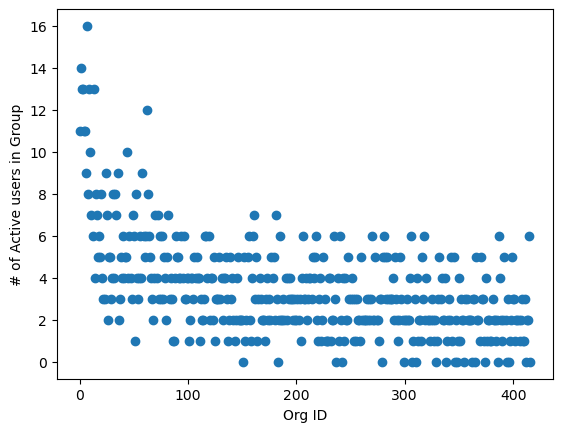

In [8]:
import seaborn
org = model_data.groupby('org_id').sum()
plt.scatter(org.index,org.Active)
plt.ylabel('# of Active users in Group')
plt.xlabel('Org ID')
plt.show()

In [9]:
org_cata = []
for i in model_data['org_id']:
    cata = org.loc[i,'Active']
    org_cata.append(cata)
model_data['org_id'] = org_cata

model_data = pd.get_dummies(data=model_data,columns=['org_id'])
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split

y = model_data.pop('Active')
x = model_data

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.25,random_state=42)


In [12]:
graboost = GradientBoostingClassifier(max_features='sqrt')
parametergra = {'n_estimators':[40,45,50,55,60],'learning_rate':[.01,0.02,0.03,0.04,0.05],
              'max_depth':[1,2,3,4,5]}
grid1 = GridSearchCV(estimator=graboost,param_grid=parametergra,
                     scoring='accuracy',cv=5)
grid1.fit(x_train,y_train)
best_para_gra = grid1.best_params_
best_acc_gra = grid1.best_score_

print('The Tuned Paratmers :\n',best_para_gra,'\nAchieved %s Percent Accuracy' %(best_acc_gra*100))


The Tuned Paratmers :
 {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 50} 
Achieved 88.0111111111111 Percent Accuracy


In [13]:
gbm = GradientBoostingClassifier(max_features='sqrt',
                                 n_estimators=45,learning_rate=.05,max_depth= 3)
gbm.fit(x_train,y_train)
feature_coef = pd.DataFrame(gbm.feature_importances_).transpose()
feature_coef.columns = list(model_data.columns)
feature_coef.index = ['GBM'] 
feature_coef.transpose().sort_values(by='GBM',ascending=False)


,GBM
creation_source_PERSONAL_PROJECTS,0.209543
org_id_5,0.150306
org_id_0,0.131109
org_id_1,0.100802
org_id_11,0.098661
org_id_6,0.081160
org_id_12,0.039821
creation_source_GUEST_INVITE,0.038456
creation_source_ORG_INVITE,0.035542
opted_in_to_mailing_list,0.019723


The above list is the importance of each feature, starting from the top as the most important. Consider the top feature 'creation_source_PERSONAL_PROJECTS' which is most important feature. Which implies these are the users who are invited to join another user'spersonal workspace. Since guest invited users, organization invited users also have high value of importance which implies users who came in by these methods tend to remain active.

